In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import ast
import networkx as nx
from collections import Counter
os.chdir("./../..")
print(os.getcwd())



/Users/adamouazzani/Documents/GitHub/ada-2024-project-theadacuates


In [3]:
df_processed = pd.read_csv('./data/output/processed_data/paths_processed.csv')   
df_raw = pd.read_csv('./data/output/base_data/raw_processed.csv') 

/var/folders/fn/4xlpvr555jx0gt6033j7x9lr0000gn/T/ipykernel_18251/1220253624.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df_processed = pd.read_csv('./data/output/processed_data/paths_processed.csv')
/var/folders/fn/4xlpvr555jx0gt6033j7x9lr0000gn/T/ipykernel_18251/1220253624.py:2: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv('./data/output/base_data/raw_processed.csv')


In [17]:
df_processed.head()

,hashed_ip,timestamp,duration,path,rating,path_list,source_link,target_link,finished,type_unfinished,...,n_back,date,click_rate,normalized_duration,freq_back,path_list_id,resolved_path_list_id,resolved_path_list_name,start_category,end_category
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN,"['14th century', '15th century', '16th century...",14th century,African slave trade,True,NaN,...,0,2011-02-15 04:26:49,0.054217,18.444444,0.0,"[10, 12, 15, 3134, 377, 105, 128, 379, 143]","[10, 12, 15, 3134, 377, 105, 128, 379, 143]","[14th century, 15th century, 16th century, Pac...",History,History
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0,"['14th century', 'Europe', 'Africa', 'Atlantic...",14th century,African slave trade,True,NaN,...,0,2012-08-12 08:36:52,0.056818,17.600000,0.0,"[10, 1433, 128, 379, 143]","[10, 1433, 128, 379, 143]","[14th century, Europe, Africa, Atlantic slave ...",History,History
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN,"['14th century', 'Niger', 'Nigeria', 'British ...",14th century,African slave trade,True,NaN,...,0,2012-10-03 23:10:40,0.057971,17.250000,0.0,"[10, 2982, 2984, 694, 3755, 128, 379, 143]","[10, 2982, 2984, 694, 3755, 128, 379, 143]","[14th century, Niger, Nigeria, British Empire,...",History,History
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN,"['14th century', 'Renaissance', 'Ancient Greec...",14th century,Greece,True,NaN,...,0,2010-02-08 08:25:25,0.108108,9.250000,0.0,"[10, 3464, 241, 1793]","[10, 3464, 241, 1793]","[14th century, Renaissance, Ancient Greece, Gr...",History,Countries
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0,"['14th century', 'Italy', 'Roman Catholic Chur...",14th century,John F. Kennedy,True,NaN,...,0,2013-04-23 17:27:08,0.040000,25.000000,0.0,"[10, 2183, 3529, 1836, 3542, 3342, 2266]","[10, 2183, 3529, 1836, 3542, 3342, 2266]","[14th century, Italy, Roman Catholic Church, H...",History,People


# 1. Compare Row counts

In [4]:
raw_row_count = df_raw.shape[0]
processed_row_count = df_processed.shape[0]
removed_paths = raw_row_count - processed_row_count

print(f"Total rows in raw data: {raw_row_count}")
print(f"Total rows in processed data: {processed_row_count}")
print(f"Paths removed during preprocessing: {removed_paths}")


Total rows in raw data: 76193
Total rows in processed data: 74114
Paths removed during preprocessing: 2079


# 2. Compare Path Completion Status

In [5]:
# Count finished vs. unfinished in raw data
raw_finished_counts = df_raw['finished'].value_counts()
print("Raw Data - Finished/Unfinished Counts:\n", raw_finished_counts)

# Count finished vs. unfinished in processed data
processed_finished_counts = df_processed['finished'].value_counts()
print("Processed Data - Finished/Unfinished Counts:\n", processed_finished_counts)


Raw Data - Finished/Unfinished Counts:
 finished
True     51318
False    24875
Name: count, dtype: int64
Processed Data - Finished/Unfinished Counts:
 finished
True     51280
False    22834
Name: count, dtype: int64


# 3. Check Balance between finished and unfinished path


In [6]:
# Calculate percentage of finished vs. unfinished paths in each dataset
raw_finished_ratio = raw_finished_counts[True] / raw_row_count
processed_finished_ratio = processed_finished_counts[True] / processed_row_count

print(f"Percentage of finished paths in raw data: {raw_finished_ratio:.2%}")
print(f"Percentage of finished paths in processed data: {processed_finished_ratio:.2%}")


Percentage of finished paths in raw data: 67.35%
Percentage of finished paths in processed data: 69.19%


# 4. Find Most Visited pages in the game

In [7]:
# Convert path_list strings to actual lists if necessary
df_processed['resolved_path_list_name'] = df_processed['resolved_path_list_name'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Flatten the list of pages and count occurrences of each page
all_pages = [page for path in df_processed['resolved_path_list_name'] for page in path]
page_counts = Counter(all_pages)

# Display the top 20 most frequent pages
top_20_pages = page_counts.most_common(20)
print("Top 20 Most Frequent Pages (Hubs):\n", top_20_pages)


Top 20 Most Frequent Pages (Hubs):
 [('United States', 13951), ('Europe', 6046), ('United Kingdom', 5888), ('England', 5054), ('Earth', 4521), ('Africa', 4001), ('World War II', 3151), ('North America', 2761), ('Animal', 2683), ('Mammal', 2661), ('Human', 2661), ('Brain', 2571), ('France', 2419), ('Germany', 2350), ('English language', 2173), ('Computer', 2151), ('Plant', 2071), ('Theatre', 2030), ('Agriculture', 2020), ('Science', 2019)]


In [8]:
# Flatten the list of pages and count occurrences of each page
all_pages = [page for path in df_processed['resolved_path_list_name'] for page in path]
page_counts = Counter(all_pages)

# Calculate total visits across all pages
total_visits = sum(page_counts.values())

# Calculate the visits for the top 20 pages
top_20_visits = sum(count for page, count in top_20_pages)

# Calculate the proportion of visits accounted for by the top 20 pages
top_20_proportion = top_20_visits / total_visits

print(f"\nThe Top 20 pages account for {top_20_proportion:.2%} of total visits in the game.")



The Top 20 pages account for 15.47% of total visits in the game.


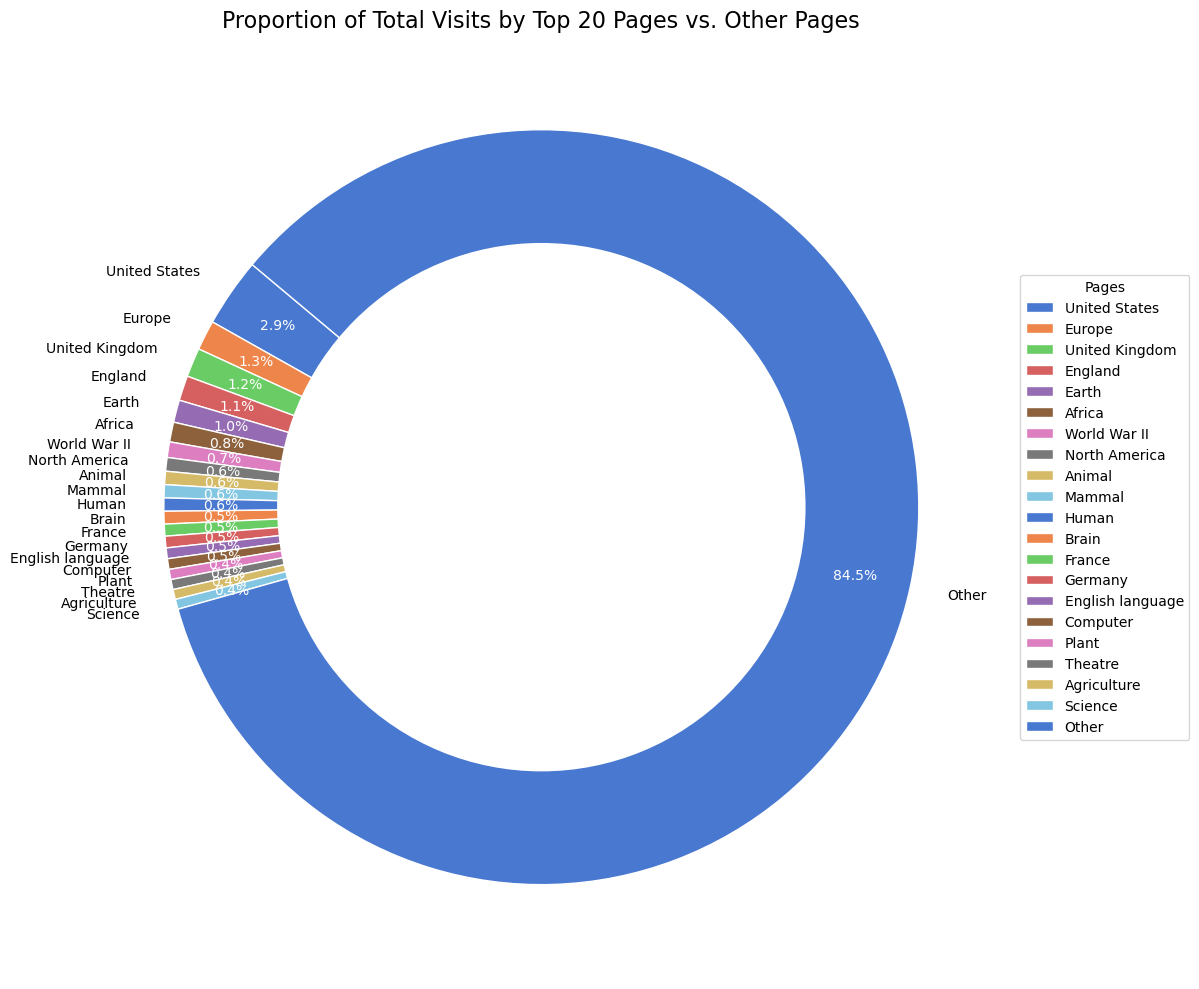

In [9]:
# Extract data for the top 20 pages
top_20_labels = [page for page, count in top_20_pages]
top_20_counts = [count for page, count in top_20_pages]

# Calculate the "Other" category for pages not in the top 20
other_count = total_visits - top_20_visits

# Add "Other" to the labels and counts
top_20_labels.append('Other')
top_20_counts.append(other_count)

# Colors - Use Seaborn color palette for a more aesthetic look
colors = sns.color_palette('muted', len(top_20_labels))

# Plot a donut chart
plt.figure(figsize=(12, 10))
wedges, texts, autotexts = plt.pie(
    top_20_counts,
    labels=top_20_labels,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    pctdistance=0.85,  # Adjust percentage text distance for a cleaner look
    wedgeprops={'edgecolor': 'w'}
)

# Draw a circle at the center to make it a donut
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
plt.gca().add_artist(centre_circle)

# Improve text properties for readability
for text in texts:
    text.set_fontsize(10)
for autotext in autotexts:
    autotext.set_fontsize(10)
    autotext.set_color('white')

# Add a legend for clarity, especially for smaller percentages
plt.legend(wedges, top_20_labels, title="Pages", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

# Add title
plt.title('Proportion of Total Visits by Top 20 Pages vs. Other Pages', fontsize=16)
plt.tight_layout()
plt.show()

# 5. Number of ingoing and outgoing links for the top hubs (# of times player clicked on the page, # of times a player quit the page)

In [22]:
df_processed['resolved_path_list_name'] = df_processed['resolved_path_list_name'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Flatten the list of all links to get outgoing and ingoing link pairs
outgoing_links = []
ingoing_links = []

for path in df_processed['resolved_path_list_name']:
    for i in range(len(path) - 1):
        source = path[i]
        target = path[i + 1]
        outgoing_links.append(source)
        ingoing_links.append(target)

# Count outgoing and ingoing links
outgoing_counts = Counter(outgoing_links)
ingoing_counts = Counter(ingoing_links)

# Display outgoing and ingoing links for the top 20 pages
top_20_pages = [page for page, count in page_counts.most_common(20)]
print("Top 20 Pages - Ingoing and Outgoing Links:")
for page in top_20_pages:
    outgoing_count = outgoing_counts.get(page, 0)
    ingoing_count = ingoing_counts.get(page, 0)
    print(f"{page}: Outgoing Links = {outgoing_count}, Ingoing Links = {ingoing_count}")

Top 20 Pages - Ingoing and Outgoing Links:
United States: Outgoing Links = 13265, Ingoing Links = 13902
Europe: Outgoing Links = 5830, Ingoing Links = 6007
United Kingdom: Outgoing Links = 5562, Ingoing Links = 5867
England: Outgoing Links = 4663, Ingoing Links = 4916
Earth: Outgoing Links = 4330, Ingoing Links = 4480
Africa: Outgoing Links = 3820, Ingoing Links = 3907
World War II: Outgoing Links = 2975, Ingoing Links = 3117
North America: Outgoing Links = 2594, Ingoing Links = 2718
Animal: Outgoing Links = 2505, Ingoing Links = 2644
Mammal: Outgoing Links = 2459, Ingoing Links = 2652
Human: Outgoing Links = 2513, Ingoing Links = 2620
Brain: Outgoing Links = 2359, Ingoing Links = 558
France: Outgoing Links = 2241, Ingoing Links = 2397
Germany: Outgoing Links = 2206, Ingoing Links = 2296
English language: Outgoing Links = 2016, Ingoing Links = 2152
Computer: Outgoing Links = 1975, Ingoing Links = 1950
Plant: Outgoing Links = 1936, Ingoing Links = 2042
Theatre: Outgoing Links = 1866, In

# 6. Categories

In [11]:
# Load categories data 
df_categories = pd.read_csv('./data/output/processed_data/categories_processed.csv')
df_categories = df_categories[['article_name', 'article_category_1']]
df_categories = df_categories.rename(columns={'article_category_1': 'primary_category'})

# Remove duplicates to ensure each article has a unique category
df_categories = df_categories.drop_duplicates(subset=['article_name'])

# Merge to add start category based on `source_link`
df_processed = df_processed.merge(
    df_categories,
    left_on='source_link',
    right_on='article_name',
    how='left'
).rename(columns={'primary_category': 'start_category'})

# Merge to add end category based on `target_link`
df_processed = df_processed.merge(
    df_categories,
    left_on='target_link',
    right_on='article_name',
    how='left'
).rename(columns={'primary_category': 'end_category'})

# Drop redundant columns from merging
df_processed = df_processed.drop(columns=['article_name_x', 'article_name_y'])

# Count paths that start in one category and end in another
category_path_counts = df_processed.groupby(['start_category', 'end_category']).size().unstack(fill_value=0)

# Display the result
print("Number of Paths by Start and End Categories:\n", category_path_counts)

Number of Paths by Start and End Categories:
 end_category             Art  Business Studies  Citizenship  Countries  \
start_category                                                           
Art                        6                14           22         13   
Business Studies          18                42           55         46   
Citizenship               17                63          144         82   
Countries                  8                31           71         65   
Design and Technology     32                54          131         75   
Everyday life             45               144          366        203   
Geography                 98               247          589        412   
History                   59                99          281        179   
IT                         6                24           49         65   
Language and literature   11                32          104         54   
Mathematics                3                11           42       

In [12]:
# Top Start Categories
top_start_categories = df_processed['start_category'].value_counts().head(10)
print("Top Start Categories:\n", top_start_categories)

# Top Finish Categories
top_finish_categories = df_processed['end_category'].value_counts().head(10)
print("\nTop Finish Categories:\n", top_finish_categories)



Top Start Categories:
 start_category
Science                    20312
Geography                  12716
Everyday life               7811
People                      6829
History                     5969
Design and Technology       4371
Language and literature     3919
Citizenship                 2915
Religion                    1989
Countries                   1707
Name: count, dtype: int64

Top Finish Categories:
 end_category
Science                    17823
Geography                  13745
Everyday life               8400
History                     7359
People                      7226
Design and Technology       4723
Citizenship                 2991
Religion                    2167
Language and literature     2027
Countries                   1992
Name: count, dtype: int64


Proportion of All Categories:
Science: 25.73%
Geography: 17.85%
Everyday life: 10.94%
People: 9.48%
History: 8.99%
Design and Technology: 6.14%
Language and literature: 4.01%
Citizenship: 3.98%
Religion: 2.80%
Countries: 2.50%
IT: 2.15%
Music: 1.86%
Business Studies: 1.75%
Mathematics: 1.03%
Art: 0.79%


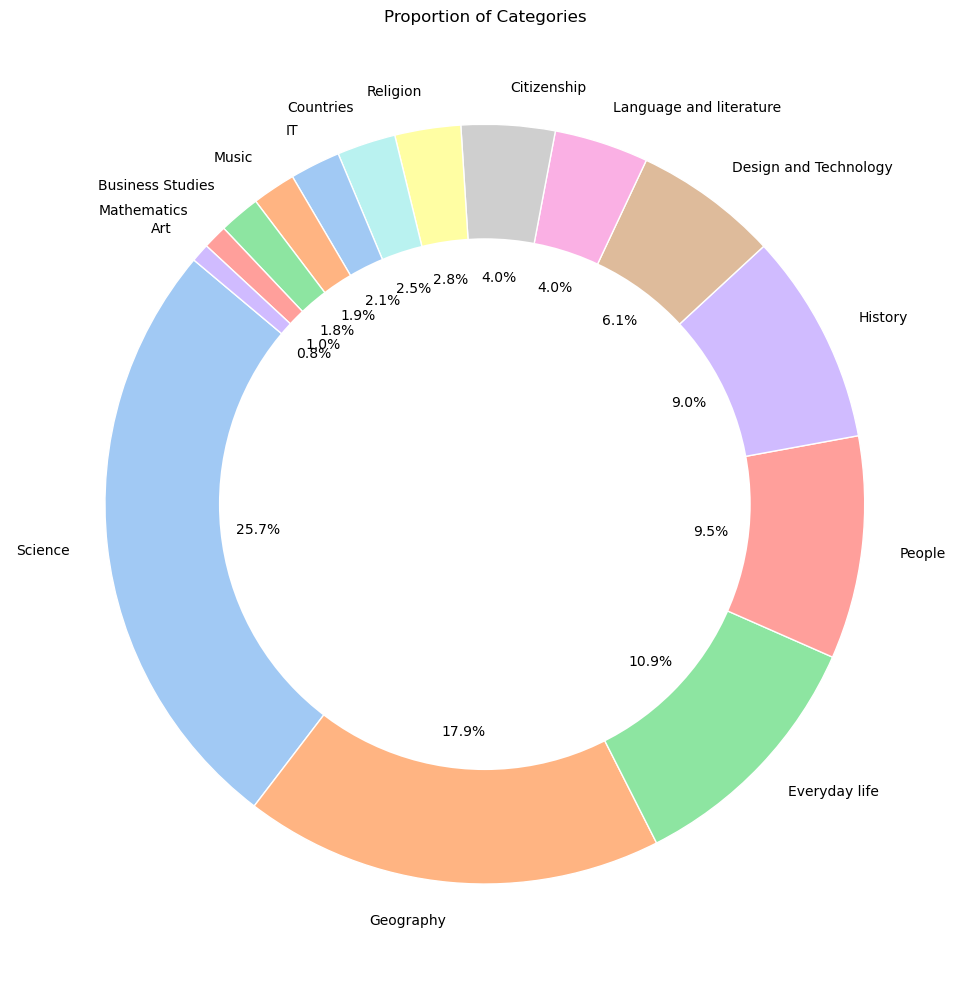

In [16]:
# Combine start and end categories into a single column to capture all categories in each path
all_categories = pd.concat([df_processed['start_category'], df_processed['end_category']])

# Drop NaN values if there are any missing categories
all_categories = all_categories.dropna()

# Calculate occurrences of each category
category_counts = all_categories.value_counts()

# Prepare data for pie chart
labels = category_counts.index.tolist()
sizes = category_counts.tolist()

# Calculate proportions
category_proportions = category_counts / category_counts.sum()

# Print proportions of all categories
print("Proportion of All Categories:")
for label, proportion in category_proportions.items():
    print(f"{label}: {proportion:.2%}")

# Plot pie chart with all categories
colors = sns.color_palette('pastel', len(labels))
plt.figure(figsize=(12, 10))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors, wedgeprops={'edgecolor': 'w'})

# Draw a circle at the center to make it a donut chart (optional)
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
plt.gca().add_artist(centre_circle)

plt.title('Proportion of Categories')
plt.tight_layout()
plt.show()

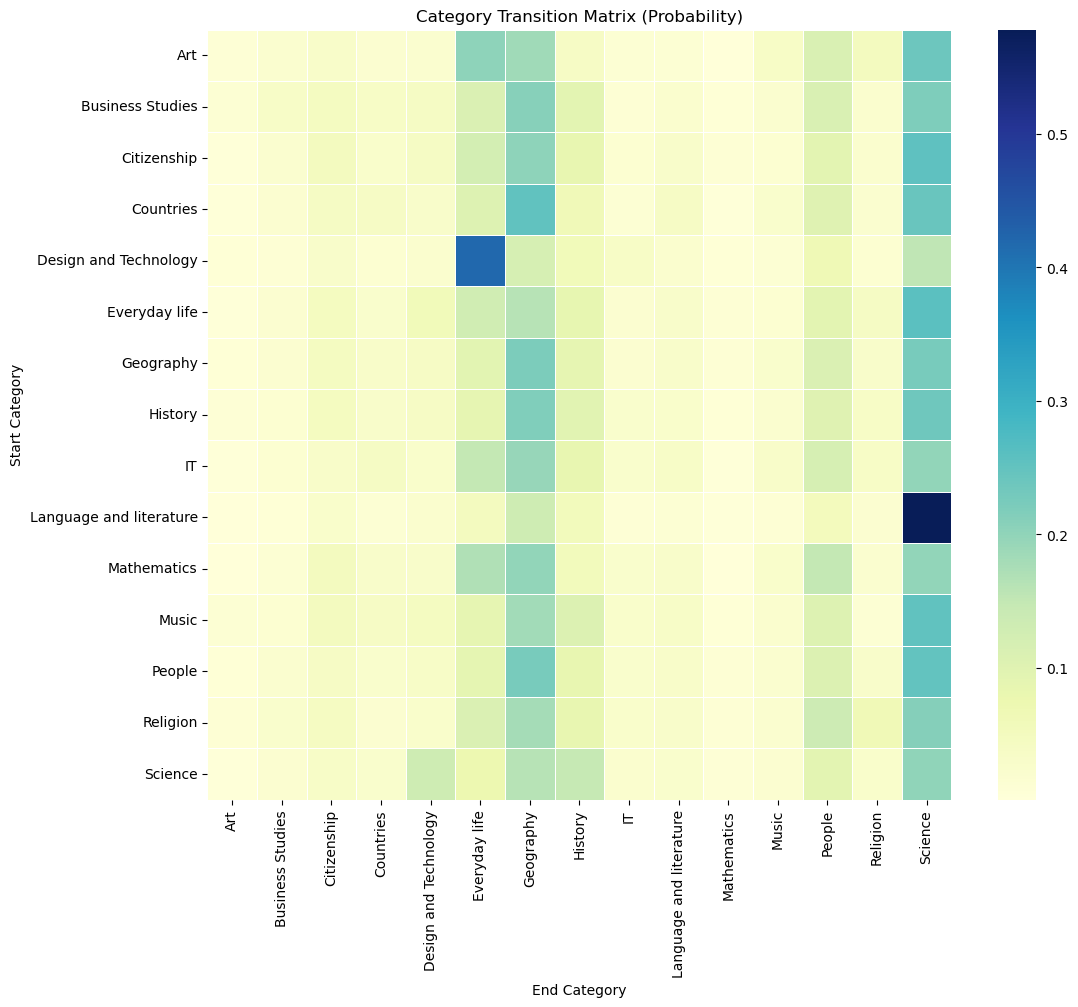

Top Category Flows:
              start_category           end_category  transition_count
224                  Science                Science              4073
216                  Science              Geography              3321
217                  Science                History              2978
104                Geography                Science              2859
96                 Geography              Geography              2820
214                  Science  Design and Technology              2689
149  Language and literature                Science              2265
89             Everyday life                Science              2026
222                  Science                 People              1894
65     Design and Technology          Everyday life              1835


In [15]:
# Step 1: Create the Transition Matrix

# Count the number of transitions from each start category to each end category
transition_counts = df_processed.groupby(['start_category', 'end_category']).size().unstack(fill_value=0)

# Convert counts to probabilities (each row will sum to 1)
transition_matrix = transition_counts.div(transition_counts.sum(axis=1), axis=0)

# Step 2: Visualize the Transition Matrix with a Heatmap

plt.figure(figsize=(12, 10))
sns.heatmap(transition_matrix, annot=False, cmap='YlGnBu', linewidths=0.5)
plt.title('Category Transition Matrix (Probability)')
plt.xlabel('End Category')
plt.ylabel('Start Category')
plt.show()

# Step 3: Track Category Flow from Start to End

# Sum the transitions for each starting category to see the flow into each ending category
category_flow = df_processed.groupby(['start_category', 'end_category']).size().reset_index(name='transition_count')

# Get the top N flows for better visualization (e.g., top 10)
top_flows = category_flow.sort_values(by='transition_count', ascending=False).head(10)

# Display top flows
print("Top Category Flows:")
print(top_flows)

# Time

/var/folders/fn/4xlpvr555jx0gt6033j7x9lr0000gn/T/ipykernel_18251/1401677656.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='hour', data=df_processed, palette='viridis')


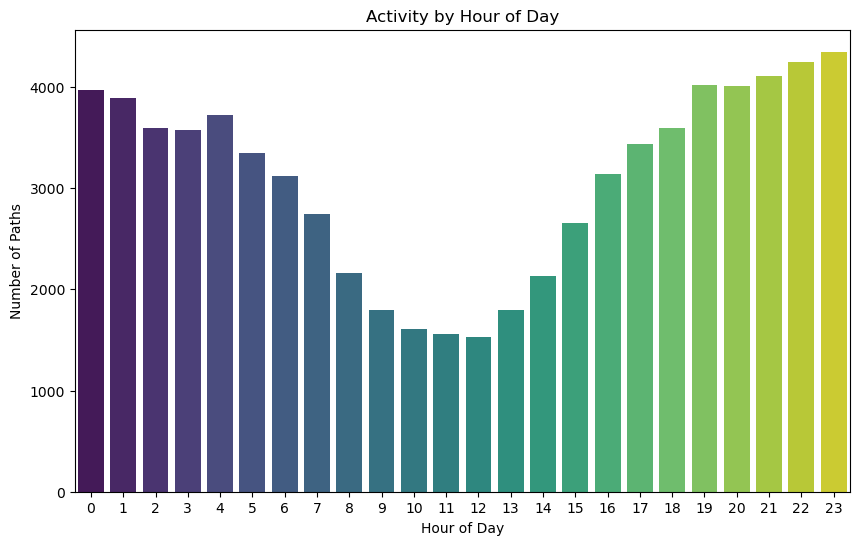

/var/folders/fn/4xlpvr555jx0gt6033j7x9lr0000gn/T/ipykernel_18251/1401677656.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='day_of_week', data=df_processed, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], palette='viridis')


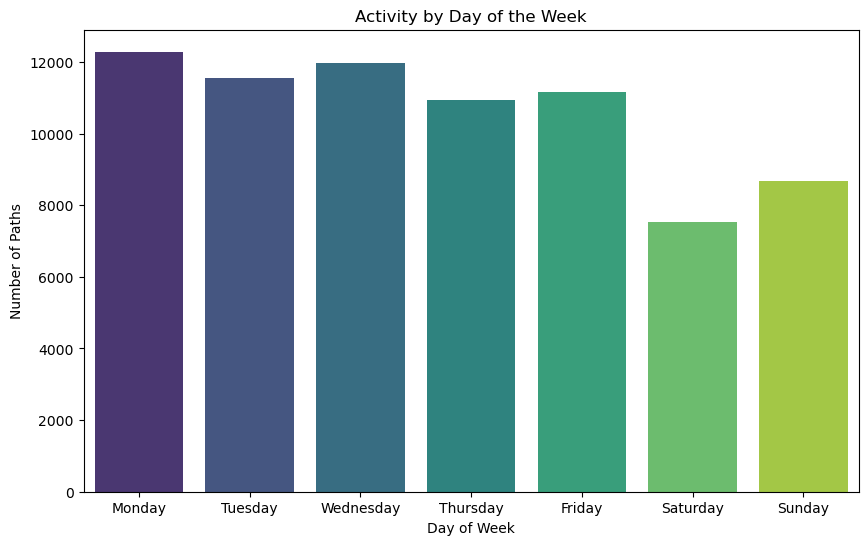

In [18]:
# Ensure the `date` column is in datetime format
df_processed['date'] = pd.to_datetime(df_processed['date'])

# Extract hour and day of the week from the `date` column
df_processed['hour'] = df_processed['date'].dt.hour
df_processed['day_of_week'] = df_processed['date'].dt.day_name()

# Plot distribution of activity by hour of the day
plt.figure(figsize=(10, 6))
sns.countplot(x='hour', data=df_processed, palette='viridis')
plt.title('Activity by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Paths')
plt.show()

# Plot distribution of activity by day of the week
plt.figure(figsize=(10, 6))
sns.countplot(x='day_of_week', data=df_processed, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], palette='viridis')
plt.title('Activity by Day of the Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Paths')
plt.show()

### Conclusion

The analysis of user activity by hour of day and day of the week reveals distinct usage patterns on the platform. Users show a marked increase in activity during the evening hours, particularly between 20:00 and 23:00, indicating that this is likely a preferred time for engagement, perhaps due to free time after daily responsibilities. Conversely, activity is lower during traditional working hours, from 9:00 to 14:00, suggesting that users may be less inclined to engage during these times. Additionally, weekday activity is consistently higher than weekend activity, with Monday showing the highest levels of engagement and Saturday the lowest. This pattern implies that users tend to start the week with more interest or motivation to explore the platform, while engagement decreases on weekends, likely due to other leisure activities.

Interestingly, the observed activity patterns diverge from typical video game engagement, where weekends generally see higher activity as people have more leisure time. In this case, however, activity is noticeably higher on weekdays, particularly on Mondays, with a decline on Saturdays and Sundays. This difference might stem from the educational context of the game, which is hosted on Wikipedia. Rather than viewing it solely as a leisure activity, users may approach it as a form of mental exercise or learning tool, treating it more like a study session or a way to expand their knowledge. This could explain why it aligns more closely with the rhythms of a weekday routine, where users might see the game as part of their intellectual exploration, training, or self-improvement rather than a traditional form of play. 

